<img src="https://github.com/Jaimegrp/Practicando/blob/main/img/cabecera.png?raw=1">

## Una (muy) breve introducción a la IA Generativa en Imágenes

Tutorial Colab:
Abrirlo con la cuenta de Jaime
Montar Drive


Lo primero un poco de historia sobre las redes generativas, principalmente de imágenes.

Autoencoders -> GAN -> Diffussion


### SUPERIMPORTANTE CAMBIAR LOS ENLACES DE ABAJO PARA QUE APUNTEN AL GITHUB DEL CURSO

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-ml3/blob/main/17_autoencoders_gans_and_diffusion_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-ml3/blob/main/17_autoencoders_gans_and_diffusion_models.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

## Autoencoders

Son redes neuronales que constan de un encoder y un decoder generalmente simétricos que se entrena con una tarea semi-supervisada o auto-supervisada. Básicamente, reproducir la entrada, sí así como suena.  

La idea es que el encoder aprenda una representación (embedding, espacio latente, etc) de la entrada que luego pueda servir para ser reconstruida. Es un extractor genérico de features :-). Luego te lo llevas al problema que quieras, pero además con un poco de magia también puede inventarse entradas (pero eso no lo vamos a ver)


<img src="https://github.com/Jaimegrp/Practicando/blob/main/img/simple_autoencoder.png?raw=1" alt="Diagrama de autoencoder" width="600"/>

Lo que se hace es "fastidiar" al enconder (pocas neuronas, meterle ruido, dropout incluso en inferencia,etc) lo que le fuerza a encontrar una representación lo más eficiente posible.

Se usan para varias cosas:
- PCA
- Lantent Analysis
- Feature Extraction
- Quitar ruído a imágenes
- Generación de imágenes



Han evolucionado y desde el modelo sencillo (también llamado stacked, porque hay varias capas en encoder y decoder) han aparecido los convolucionales que usan capas convolucionales y los Varational Autoencoders (VAE) en los que la salida del Encoder tiene un poco de aleatoriedad (que luego permitirá que sean generativos, o sea creen instancias sintéticas no existentes en los datasets de entrenamiento)

Para entender un poco más los GAN sólo un inciso, las capas convolucionales transpuestas, son capas que reciben la salida de otras capas convolucionales y devuelven la salida de sus filtros con la resolución de entrada a esas otras capas convolucionales

<img src="https://github.com/Jaimegrp/Practicando/blob/main/img/transposed_Deconvolution.webp?raw=1" alt="Inversa y Transpuesta de una convolucional" height="200"/>

En un autonencoder, si en el encoder (Conv2D) hay convolucionales en el decoder hay transpuestas (Conv2DTranspose)

## GANs

Son dos redes neuronales con misiones contrapuestas. Una (la denominada Generator) tiene como objetivo crear instancias falsas o sintéticas que la otra (denominada Discriminator) debe clasificar como verdaderas, mientas que la misión del Discriminator es la de aprender cuáles son las falsas.

<img src="https://github.com/Jaimegrp/Practicando/blob/main/img/GAN.jpg?raw=1" alt="Diagrama sencillo GAN" width="1000"/>

Para entenderlas un poco mejor, merece la pena conocer cómo se entrenan (porque no es cómo en las redes vistas hasta ahora):
1. Primero al batch de imágenes reales se le añade otro batch de imágenes falsas. Estas imágenes falsas se crean metiendo ruido gaussiano (tiramos muchas veces un gran dado "especial" que sigue una distribución estadística gaussiana, las caras del dado no tienen las mismas probabilidades de salir :-)). Tiramos tantas veces nuestro "dado gaussiano" como "features" (llamadas codings) queramos darle de comer. Nuestro Generador creará tantas imágenes como haga falta haciendo pasar la entrada aleatoria por sus capas (sí, claro, las primeras veces será un manchurrón porque los pesos del Generador no están entrenados) y las mezclamos con el batch de imágenes reales.
2. A las imagénes reales les asignamos la clase 1, por ejemplo, y a las falsas la clase 0. Ahora entrenamos sólo el Discriminador (que las primeras veces lo tendrá chupao).
3. "congelamos" el discriminador (es decir evitamos que sus capas sean entrenadas en la siguiente parte)
4. Ahora sí, usamos toda la red Generator seguido de Discriminator para entrenar (pero como hemos hecho 3. sólo se entrenará el Generator, ingenioso, eh?)
5. Y, ¿cómo? Pasamos otras "tiradas de dados" como entradas (si pasasemos las mismas que en 1 y 2 entonces el Discriminator tendría ventaja que ya las ha visto con su etiqueta de verdad), el Generator, generará las mismas imágenes fake, pero a estas las etiquetasmos como reales y las pasamos por el Discriminator. Ahora cada vez que el Discriminator diga que es fake (mucho al principio) los pesos de las capas del Generator se irán configurando para poder engañar al Discriminator...

Y voilá... Veámoslo con código

# Setup

This project requires Python 3.7 or above:

In [1]:
import sys

assert sys.version_info >= (3, 7)

It also requires Scikit-Learn ≥ 1.0.1:

In [2]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

And TensorFlow ≥ 2.8:

In [3]:
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

Algunos ajustes para cuando lancemos nuestro entrenamiento de redes GAN

In [4]:
import numpy as np
import matplotlib.pyplot as plt


from time import time

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

Comprobación de si tenemos GPU a mano, porque si no ya te puedes ir a tomar un desayuno, comida o cena.

In [5]:
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if "google.colab" in sys.modules:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if "kaggle_secrets" in sys.modules:
        print("Go to Settings > Accelerator and select GPU.")

Utilizaremos el FMNIST, ese gran amigo nuestro de ropas y complementos

In [6]:
# extra code – loads, scales, and splits the fashion MNIST dataset
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

4422102/4422102 [==============================] - 1s 0us/step


Y un poco de código para poder pintar las imágenes:

In [7]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = images.squeeze(axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")


# Generative Adversarial Networks

In [8]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

codings_size = 30

# Creamos un modelo para el discriminador y un modelo para el generador. Una vez entrenado este último nos permitirá crear caras (eso sí, de forma aleatoria, no podremos guiar el proceso)

Dense = tf.keras.layers.Dense
generator = tf.keras.Sequential([
    Dense(100, activation="relu", kernel_initializer="he_normal"),
    Dense(150, activation="relu", kernel_initializer="he_normal"),
    Dense(28 * 28, activation="sigmoid"),
    tf.keras.layers.Reshape([28, 28]) # Convertimos la salida del generador en "imágenes" de 28x28
])
discriminator = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    Dense(150, activation="relu", kernel_initializer="he_normal"),
    Dense(100, activation="relu", kernel_initializer="he_normal"),
    Dense(1, activation="sigmoid") # Un clasificador binario en DL como los que hemos visto varias veces
])
gan = tf.keras.Sequential([generator, discriminator])

In [9]:
# Primer truco para entrenar, creamos un modelo para el discriminador y un modelo con generador y discriminador, pero con las capas del discriminador "congeladas"
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [10]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

Epoch 1/50


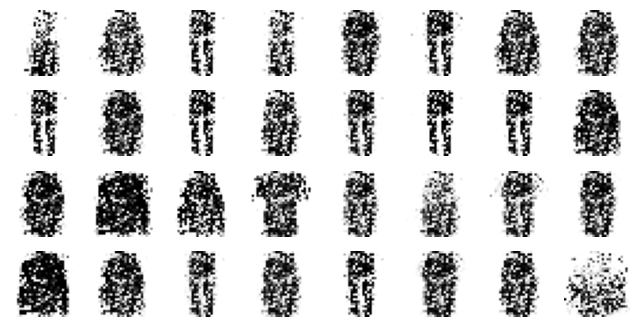

Epoch 2/50


KeyboardInterrupt: 

In [11]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print(f"Epoch {epoch + 1}/{n_epochs}")  # extra code
        for X_batch in dataset:
            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size]) # Generamos unas tiradas de dados para hacer las imágenes falsas
            generated_images = generator(noise) # Generamos las imágenes fake pasándoloas por el Generator tal cual esté en ese momento, (a medida que se vayan generando batches irá mejoran)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0) # Mezclamos falsas (generated_images) y reales (X_batch)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size) # Asignamos 0 a las falsas y 1 a las reales
            discriminator.train_on_batch(X_fake_and_real, y1) # Entrenamos, utilzando el método especial de entrenar en un sólo batch y aprovechamos que los modelos se entrenan progresivamente :-), no se pierden los pesos al volver a entrenar
            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size]) # Nuevas tiradas para no dar ventaja al Discriminator, y que serán la entrada a toda la GAN
            y2 = tf.constant([[1.]] * batch_size) # Preparamos la trampa para el Discriminator, le vamos a decir que todas son reales (por eso tenemos que congelar los pesos del Discriminator sino aprendería a decir que sí a todas las imágenes fake)
            gan.train_on_batch(noise, y2) # Utilizamos el modelo GAN, que en realidad sólo está entrenando las capas del Generator
        # extra code — plot images during training
        plot_multiple_images(generated_images.numpy(), 8) # Para ver como el Generator va mejorando
        plt.show()

train_gan(gan, dataset, batch_size, codings_size, n_epochs=50)

Y ahora que ya lo hemos entrenado, juguemos un poco

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

codings = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator.predict(codings)

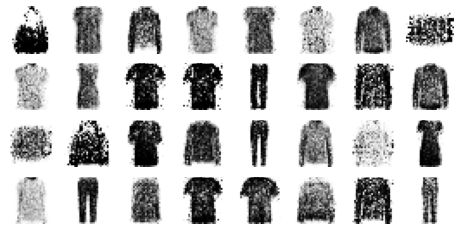

In [ ]:
# extra code – this cell generates and saves Figure 17–15
plot_multiple_images(generated_images, 8)
save_fig("gan_generated_images_plot", tight_layout=False)
plt.show()

## Evolución de las GAN: StyleGANs

__Deep Convolutional GANs (DCGAN)__: Las GAN que hemos visto usan capas densas, lo siguiente fue incluir capas Convolucionaes Transpuestas en el Generator y Convolucionales al Discriminator y hacer algunos truquis para que el entrenamiento fuera estable (no se llegaran a "acuerdos" entre Discrimiantor y Generator, como, por ejemplo, lo que se conoce como Mode Collapse).

__Progressive DCGAN__: En 2018, ese año, los investigadores de Nvidia introdujeron nuevas mejoras, siendo la principal la arquitectura de la red es dinámica en entrenamiento (se van añadiendo capas convolucionales a medida que se entrena) y otros elementos para hacerla estable.

__StyleGANs__: No mucho después, introdujeron cambios que dieron un salto cualitativo destacado. Básicamente cambiaron la arquitectura del Generator de forma que ahora tenía a su vez dos partes: Mapping Network y Synthesis Network (ambas entrenables)



<img src="https://github.com/Jaimegrp/Practicando/blob/main/img/styleGAN.webp?raw=1" drawing = "Diagrama de un Generator de una StyleGAN" width ="600" />

Lo diferencial, es que la mapping network es como un superembedding de las imágenes (Creado antes de sintetizar las imágenes) que da un vector por imagen (w, también style vector) base y luego este vector se pasa por las capas de transformación (A) que generan otros subvectores que ya sí entran el módulo de synthsis que genera la imagen aleatoria.  

Lo potente además de que se generen imágenes cada vez más realistas es que una vez entrenado este Generator, se pueden tocar las cajas A y sobre una misma imagen generada podemos cambiar las características (el color del pelo, la edad, el humor, etc). De hecho también podemos cambiar la imagen de partida tocando el vector w.
  
Lo que no podemos así tal cual es tocar foto que no haya sido generada por el sistema (tened en cuenta que se le dan tiradas aleatorias de dados para comer). Por supuesto hay aplicaciones que son capaces de sacar el vector w de una imagen dada y luego aplicar una red de synthesis preentrenadas.

Veámoslo!!!
* [Which Face is Real](http://www.whichfaceisreal.com/)

# Diffusion Models...

Muy resumidadmente, los modelos de difusion (no son GAN), son redes a las que se les pasa como entrenamiento imágenes a las que se les ha aplicado ruido de forma progresiva (a cada pixel se le ha ido añadiendo un número aleatorio pequeñito progresivamente) y el ruido. La red aprende que dada una imagen con ruido, cuál es el ruido. Luego se le da "ruido" (nunca hubo imagen, y llamémoslo manchurón del principio), pero no se le indica que sea así y la red predice el que cree que sería el ruido de haber una imagen real detrás, y vamos quitando capas y sale la imagen (hallucinated que se dice técnicamente) a la que habríamos tenido que añadir el ruido que ha "supuesto" la red para que saliera el manchurrón del principio.

Imagen_X + un poco de manchurrón -> imagen_1  (la red tiene que aprender el "poco de manchurrón")  

imagen1 + otro poco de manchurrón -> imagen_2 (la red tiene que aprender el "otro poco de manchurrón")
  
imagen2 + más poco manchurrón -> imagen_3 (la red tiene que aprender "más poco manchurrón")  

....
....
...
imagen3999 + poquito final de manchurrón -> imagen4000  (que ahora será un buen manchurrón completo indistinguible para el ojo humano) -> la red tiene que aprender "poquito final de manchurrón".

<img src="https://github.com/Jaimegrp/Practicando/blob/main/img/diffusion_forward.png?raw=1" alt ="Proceso forward de diffusion" width = "800"/>

Y así con millones de imágenes...

El modelo está preparado para...

Supermanchurrón (sin imagen detrás) model.predict(Supermanchurrón) -> poquito_final (la red predice aunque no tenga sentido, rember?)  

Supermanchurrón-un poquito_final -> model.predict(Supermanchurrón-un_poquito_final) -> un poquito menos de manchurrón  

Supermanchurrón-un poquito_final - un poquito menos de manchurrón -> model.predict....  
  

.....
Supermanchurrón sin todos los 4000 preditct manchurroncitos -> Lo que sea que dios quiera, pero siempre en en el espacio latente de las imágenes que le he dado es decir una combinación de las imágenes de partida -> MAGIA!!!  

<img src="https://github.com/Jaimegrp/Practicando/blob/main/img/denoising_diffusion.jpg?raw=1" alt = "Proces de quitar ruido en Diffusion" width = "800"/>

### ... y aprendizaje condicional

Además a estos sitemas se les ha añadido entrenamiento con aprendizaje condicional. Básicamente el aprendizaje condicional se da cuando a nuestro datase de entrada le añadimos "condiciones" (features extra). En este caso el modelo actual (Mar2023) es Stable Diffusion, que ha sido entrenado con millones y millones de imágenes a las que se ha condicionado con un texto descriptivo.  

A la hora entrenar a la imagen además de añadir el ruido se le añade una "vectorización" del texto de caption (algo así como su embedding) de forma que a la hora de hacer el denoising la red no "intuye" el poquito de manchurrón que tiene la imagen, sino el poquito de manchurrón condicionado al texto que se le dé de entrada.

Para saber más (jugando con ello, que ya podéis perfectamente)


https://keras.io/guides/keras_cv/generate_images_with_stable_diffusion/

https://keras.io/examples/generative/finetune_stable_diffusion/

Me falta:

- Darles más ejemplos de Stable -> Cuáles son los modelos que ellos pueden acceder, y como finetunearlos (Actualizar esta parte)
- El notebook del vídeo al final (encontrarlo y probarlo) y probar los notebooks
- Preparar un pack para que ello prueben el resto de notebooks -> Probarlo con las fotos de Morena y ver qué sale :-) (lo ideal sería probarlo con morena y con S.)
- Repasar la teoría y repasar el contenido teórico del notebook


La clase:
1- Conectarse a Google Colab, crearse una cuenta, arrancar, cuatro detalles (30 min)
2- Intro Variatonal Encoders, GAN, Difusion. Con entrenamiento de GAN. Ejemplos de sitios de difusion, pinceladas para hacer un finetuning de su modelo de difusion (45 min)
    - Probar true or false
    - Meter el entrenamiento de una GAN
3- SI da tiempo, stylized GAN para que jueguen (30 min)
4- Si da tiempo, presentarles como finetunear una difussion para que usen sus propias imágenes (20 min)
4- Si da tiempo, explicarles el pack de contenido extra (15 min)

Plan de curro:

1. Probar el script en ordenador (el de GANs) [pre-comida]
2. Probar script de ordenador en Colab y script stylzed GAN en Colab -> Minirefamiliarización con Colab [Actualizar Stylzed GAN a lo que NVIDA tenga ahora]
    - Revisar el taller de Colab [Pre-merienda]
3. Revisar la parte teórica: Completar la parte de difusión y la de Stylized GAN [Post-merienda/madrugada]
    - Revisar todo el entrenamiento
    - Probar true or false
    - Actualizar toda la parte de difusion -> Ponerse al día
4. Preparar pack DIY [posiblemente se caiga]q